<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/Cours2025/JAX_blob_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Score-Based Diffusion modeling

This demo is inspired by [Yang Song blog 2021](https://yang-song.net/blog/2021/score/) especialy the "JAX-Based tutorial"
that I have rewrited to be run with current FLAX/Optax library.
The mathematial support is given in [Yang Song et al. Score-Based Generative Modeling through Stochastic Differential Equations](https://arxiv.org/pdf/2011.13456) (especialy Section 3 and 4).

In this demo you will train a time-dependent score-model on multi-gaussian modes distribution
and use two kind of solvers to generate new samples. You can play with the parameters notably
the number of modes, and the sampler type. Of course, you are free to change the model, the trainig and the sampling.
This nb is just a guide.

I have also modified the MNIST use case.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Run it on a TPU (if possible)!
import jax.tools.colab_tpu
try:
  jax.tools.colab_tpu.setup_tpu()
except:
  pass


In [3]:
from functools import partial

import jax
import jax.numpy as jnp
import numpy as np

from typing import Any, Tuple

PRNGKey = jnp.ndarray

num_devices = jax.device_count()

In [4]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [7]:
!pip install -q dm-haiku

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.9/373.9 kB 12.9 MB/s eta 0:00:00


In [8]:
import haiku as hk

# Init

In [9]:
args = {
    'x_dim': 2,
    'seed': 2025,
}
args['num_blobs'] = 4
args['x_lim'] = 1

# Set the parallel batch size.
args['batch_size'] = num_devices * 512 if num_devices > 1 else  512
args['epochs'] = 1500  # min: 500. More <=> less samples between the blobs...
args['batch_size_p'] = args['batch_size'] //  num_devices

args['sigma_max'] = 15.0

# Dataset

In [10]:
def make_dataset_gaussian_blobs(
    seed: int,
    batch_size: int = 1,
    num_batches: int = 1,
    num_blobs: int = args['num_blobs'],
    r: float = 1.0,
    SCALE: float = 0.1
):
    prng_seq = hk.PRNGSequence(seed)
    offset = 0  # jnp.pi / num_blobs
    thetas = jnp.linspace(offset, 2 * jnp.pi + offset, num_blobs, endpoint=False)
    x = r * jnp.cos(thetas)
    y = r * jnp.sin(thetas)
    loc = jnp.stack([x, y], axis=-1)

    dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(
            probs=[1 / num_blobs for _ in range(num_blobs)]
        ),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=loc, scale_diag=SCALE * jnp.ones((num_blobs, 2))
        ),
    )

    for _ in range(num_batches):
        key = next(prng_seq)
        data = dist.sample(seed=key, sample_shape=(batch_size,))
        yield data/(2*jnp.max(jnp.abs(data))) + jnp.ones((batch_size,2))*0.5



make_dataset = make_dataset_gaussian_blobs
xlim, ylim = [0,args['x_lim'] ], [0,args['x_lim'] ]


In [11]:
dataset_size = 100_000
batches_in_epoch = dataset_size // args['batch_size']
dataset_size = batches_in_epoch * args['batch_size']

print(dataset_size, batches_in_epoch)

data_batch = make_dataset(
        seed=args['seed'], batch_size=dataset_size, num_batches=1   # keep batch_size a multiple of args['batch_size']
    )
X_train = next(data_batch)
#X_train = jax.random.uniform(jax.random.PRNGKey(111), shape=(args['batch_size']*40,2))

99840 195


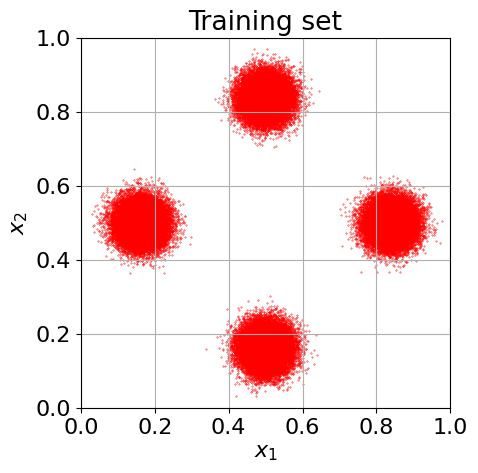

In [12]:
plt.scatter(X_train[:, 0], X_train[:, 1], s=0.1, color='red',label='Train')
plt.title("Training set")
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect('equal')
plt.grid()

In [13]:
import itertools
data_gen = itertools.cycle(jnp.array(jnp.array_split(jax.random.permutation(jax.random.PRNGKey(42),X_train), batches_in_epoch )))

# ScoreNet simple architecture

In [16]:
import functools
from typing import Any, Callable, Sequence, Optional
import jax
#from jax import lax, random, numpy as jnp
from jax.nn.initializers import normal as normal_init


import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
from flax import struct, serialization
from flax.linen.initializers import glorot_normal

import orbax.checkpoint

import optax
import os

In [17]:
def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  return jnp.sqrt((sigma**(2 * t) - 1.) / 2. / jnp.log(sigma))


#sigma =  args['sigma_max']#  was 25 MINST args['sigma_max']
marginal_prob_std_fn = partial(marginal_prob_std, sigma=args['sigma_max'])

In [18]:
TrainState = train_state.TrainState

#default_kernel_init = glorot_normal()

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  embed_dim: int
  scale: float = 30.
  @nn.compact
  def __call__(self, x):
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    W = self.param('W', jax.nn.initializers.normal(stddev=self.scale),
                 (self.embed_dim // 2, ))
    W = jax.lax.stop_gradient(W)
    x_proj = x[:, None] * W[None, :] * 2 * jnp.pi
    return jnp.concatenate([jnp.sin(x_proj), jnp.cos(x_proj)], axis=-1)


class ScoreNet(nn.Module):

  marginal_prob_std: Any
  channels: Tuple[int] =  (32, 64, 128, 256)
  embed_dim: int = 256

  @nn.compact
  def __call__(self, x, t):
    # The swish activation function
    act = nn.swish
    # Obtain the Gaussian random feature embedding for t
    embed = act(nn.Dense(self.embed_dim)(
        GaussianFourierProjection(embed_dim=self.embed_dim)(t)))
    #print("embed shape", embed.shape)
    #print("0) x.shape",x.shape)

    h1 = nn.Dense(self.channels[0],use_bias=False)(x)
    #print("0) h1.shape",h1.shape)
    h1 += nn.Dense(self.channels[0])(embed)
    #print("1) h1.shape",h1.shape)
    h1 = nn.GroupNorm(4)(h1)
    h1 = act(h1)
    #print("3) h1.shape",h1.shape)

    h2 = nn.Dense(self.channels[1],use_bias=False)(h1)
    h2 += nn.Dense(self.channels[1])(embed)
    h2 = nn.GroupNorm()(h2)
    h2 = act(h2)
    #print("0) h2 shape:",h2.shape)

    h3 = nn.Dense(self.channels[2],use_bias=False)(h2)
    h3 += nn.Dense(self.channels[2])(embed)
    h3 = nn.GroupNorm()(h3)
    h3 = act(h3)
    #print("0) h3 shape:",h3.shape)

    h4 = nn.Dense(self.channels[3],use_bias=False)(h3)
    h4 += nn.Dense(self.channels[3])(embed)
    h4 = nn.GroupNorm()(h4)
    h4 = act(h4)
    #print("0) h4 shape:",h4.shape)

    # Decoding path
    h = nn.Dense(self.channels[2], use_bias=False)(h4)
    ## Skip connection from the encoding path
    h += nn.Dense(self.channels[2])(embed)
    h = nn.GroupNorm()(h)
    h = act(h)
    #print("0) h shape:",h.shape)

    #print("[h,h3] shape:", jnp.concatenate([h, h3], axis=-1).shape)
    h = nn.Dense(self.channels[1], use_bias=False)(
                      jnp.concatenate([h, h3], axis=-1)
                  )
    h += nn.Dense(self.channels[1])(embed)
    h = nn.GroupNorm()(h)
    h = act(h)
    #print("1) h shape:",h.shape)


    #print("[h,h2] shape:", jnp.concatenate([h, h2], axis=-1).shape)
    h = nn.Dense(self.channels[0], use_bias=False)(
                      jnp.concatenate([h, h2], axis=-1)
                  )
    h += nn.Dense(self.channels[0])(embed)
    h = nn.GroupNorm()(h)
    h = act(h)
    #print("2) h shape:",h.shape)

    #print("[h,h1] shape:", jnp.concatenate([h, h1], axis=-1).shape)
    h = nn.Dense(2)(
        jnp.concatenate([h, h1], axis=-1)
    )
    #print("3) h shape:",h.shape)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None]

    return h

# LOss

In [19]:
@partial(jax.pmap, axis_name='num_devices')
def scorenet_step(scorenet_state: TrainState,
                  x: jnp.ndarray,
                  key: PRNGKey):
  r""" blabla
  """

  key, key_std, key_noise = jax.random.split(key,3)
  random_t = jax.random.uniform(key_std, (x.shape[0],), minval=1e-5, maxval=1.)
  std = marginal_prob_std_fn(random_t)
  z = jax.random.normal(key_noise, x.shape)
  perturbed_x = x + z * std[:,None]

  def loss_fn(params):
    score = scorenet_state.apply_fn(
        {'params': params},
        perturbed_x, random_t)

    loss = jnp.mean(jnp.sum((score * std[:, None] + z)**2, axis=1))

    return loss

  grad_fn = jax.value_and_grad(loss_fn)
  loss,  grads = grad_fn(scorenet_state.params)


  # Average across the devices.
  grads = jax.lax.pmean(grads, axis_name='num_devices')
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  new_scorenet_state = scorenet_state.apply_gradients(
      grads=grads)

  return loss, new_scorenet_state    #mind order

# Training
restart from here if you want to change training parameters

In [20]:
def piecewise_constant_schedule(
    init_value, boundaries_and_scales = None
):
  """Returns a function which implements a piecewise constant schedule.

  Args:
    init_value: An initial value ``init_v``.
    boundaries_and_scales: A map from boundaries ``b_i`` to non-negative scaling
      factors ``f_i``. For any step count `s`, the schedule returns ``init_v``
      scaled by the product of all factors ``f_i`` such that ``b_i < s``.

  Returns:
    schedule
      A function that maps step counts to values.
  """

  def schedule(count):
    v = init_value
    if boundaries_and_scales is not None:
      for threshold, scale in sorted(boundaries_and_scales.items()):
        indicator = jnp.maximum(0.0, jnp.sign(threshold - count))
        v = v * indicator + (1 - indicator) * scale * v
        jax.debug.print("lr: = {}",v)
    return v

  return schedule

In [21]:
# Training scheduler
total_steps = (args['epochs']+1) * batches_in_epoch
print(total_steps)
schedule_fn = optax.piecewise_constant_schedule(init_value=1e-3,
        boundaries_and_scales={int(total_steps*0.33):0.1,
                               int(total_steps*0.66):0.1})

292695


In [22]:
@partial(jax.pmap, static_broadcasted_argnums=(1))
def create_state(rng, model):
  r"""Create the training state given a model class. """

  tx = optax.adam(learning_rate=schedule_fn)
  fake_input = jnp.ones((args['batch_size_p'], args['x_dim']))
  fake_time = jnp.ones(args['batch_size_p'])

  variables = model.init(rng, fake_input, fake_time)
  params = variables["params"]

  state = TrainState.create(apply_fn=model.apply,
                            params=params,
                            tx=tx)

  return state

In [23]:
from flax.training.common_utils import shard, shard_prng_key

key = jax.random.PRNGKey(seed=args['seed'])
key_scorenet, key = jax.random.split(key, 2)
key_scorenet = shard_prng_key(key_scorenet)

scorenet_state = create_state(key_scorenet, ScoreNet(marginal_prob_std_fn))

In [24]:
key, key_scorenet = jax.random.split(key, 2)
key_scorenet = shard_prng_key(key_scorenet)

# Shard the data to possible devices.
batch_data = shard(next(data_gen))

# Take a step with the scorenet
scorenet_loss,  scorenet_state = scorenet_step(scorenet_state,
          batch_data, key_scorenet)


In [25]:
import os
import shutil

from tqdm.notebook import tqdm

In [26]:
info_losses=[]
loss_best = jnp.inf

pbar = tqdm(range(1, args['epochs'] + 1))
for epoch in pbar:
    loss_mean = 0.
    for batch in range(batches_in_epoch):
      # Generate RNG keys for denoiser
      key, key_scorenet = jax.random.split(key, 2)
      key_scorenet = shard_prng_key(key_scorenet)

      # Shard the data to possible devices.
      batch_data = shard(next(data_gen))
      # Take a step with the denoiser.
      scorenet_loss,  scorenet_state = scorenet_step(scorenet_state,
          batch_data, key_scorenet)
      loss_mean +=  jax.device_get([scorenet_loss[0]])[0]

    loss_mean = loss_mean/batches_in_epoch
    pbar.set_description(f"Epoch {epoch}")
    pbar.set_postfix(loss=loss_mean)
    info_losses.append(loss_mean)
    #save best
    if loss_mean < loss_best:
      loss_best = loss_mean
      epoch_best = epoch
      best_state = scorenet_state
      #I/O should be fixed
      #ckpt = {'model': flax.jax_utils.unreplicate(best_state)}
      #save_args = orbax_utils.save_args_from_target(ckpt)
      #checkpoint_manager.save(epoch_best, ckpt, save_kwargs={'save_args': save_args})


  0%|          | 0/1500 [00:00<?, ?it/s]

# Plots

In [27]:
import numpy as np

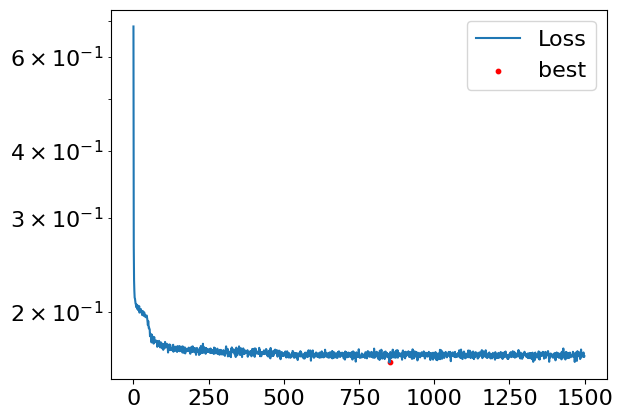

In [28]:
info_losses = np.array(info_losses)
plt.plot(info_losses,label='Loss')
plt.scatter(epoch_best,loss_best,s=10,c='r',label='best')
plt.yscale('log')
#plt.xlim([0,10])
#plt.ylim([info_den_losses.min()/2,1])
plt.legend();

# Sampling

In [36]:
def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return sigma**t
diffusion_coeff_fn = partial(diffusion_coeff, sigma=args['sigma_max'])

In [37]:
from flax.training import orbax_utils
from flax.serialization import to_bytes, from_bytes

from tqdm.notebook import tqdm
#import tensorflow as tf

In [38]:
signal_to_noise_ratio = 0.16 #0.16

def score_fn(score_state, x, t):
  score = score_state.apply_fn(
        {'params': score_state.params},
        x, t)
  #print("score_fn: x.shape",x.shape,"t.shape",t.shape,"score.shqpe",score.shape)
  return score # score_state.apply(params, x, t)

pmap_score_fn = jax.pmap(score_fn, axis_name='num_devices')

## The number of sampling steps.
num_steps =  500
def pc_sampler(rng,
               score_state,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               snr=signal_to_noise_ratio,
               eps=1e-3):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    rng: A JAX random state.
    score_model: A `flax.linen.Module` that represents the
      architecture of the score-based model.
    params: A dictionary that contains the parameters of the score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  time_shape = (jax.local_device_count(), batch_size // jax.local_device_count()) # (#dev, B)
  sample_shape = (*time_shape, args['x_dim'])       # (#dev, B, 2)
  rng, step_rng = jax.random.split(rng)
  init_x = jax.random.normal(step_rng, sample_shape) * marginal_prob_std(1.)
  time_steps = jnp.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  #print("init_x shape:",init_x.shape)
  for time_step in tqdm(time_steps):
    batch_time_step = jnp.ones(time_shape) * time_step
    # Corrector step (Langevin MCMC)
    #print("x shape:",x.shape)
    #print("batch_time_step shape:",batch_time_step.shape)
    grad = pmap_score_fn(score_state, x, batch_time_step)
    #print("grad shape:",grad.shape)
    #break
    grad_norm = jnp.linalg.norm(grad.reshape(sample_shape[0], sample_shape[1], -1),
                                axis=-1).mean()
    noise_norm = np.sqrt(np.prod(x.shape[1:]))
    langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
    rng, step_rng = jax.random.split(rng)
    z = jax.random.normal(step_rng, x.shape)
    x = x + langevin_step_size * grad + jnp.sqrt(2 * langevin_step_size) * z

    # Predictor step (Euler-Maruyama)
    g = diffusion_coeff(time_step)
    score = pmap_score_fn(score_state, x, batch_time_step)
    x_mean = x + (g**2) * score * step_size
    rng, step_rng = jax.random.split(rng)
    z = jax.random.normal(step_rng, x.shape)
    x = x_mean + jnp.sqrt(g**2 * step_size) * z

  # The last step does not include any noise
  return x_mean

In [39]:
#@title Define the ODE sampler (double click to expand or collapse)

from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(rng,
                score_state,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                z=None,
                eps=1e-5):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    rng: A JAX random state.
    score_model: A `flax.linen.Module` object  that represents architecture
      of the score-based model.
    params: A dictionary that contains model parameters.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """

  #time_shape = (jax.local_device_count(), batch_size // jax.local_device_count())
  #sample_shape = time_shape + (1, args['x_dim'])
  time_shape = (jax.local_device_count(), batch_size // jax.local_device_count()) # (#dev, B)
  sample_shape = (*time_shape, args['x_dim'])       # (#dev, B, 2)

  # Create the latent code
  if z is None:
    rng, step_rng = jax.random.split(rng)
    z = jax.random.normal(step_rng, sample_shape)
    init_x = z * marginal_prob_std(1.)
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = jnp.asarray(sample, dtype=jnp.float32).reshape(sample_shape)
    time_steps = jnp.asarray(time_steps).reshape(time_shape)
    score = pmap_score_fn(score_state, sample, time_steps)
    return np.asarray(score).reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones(time_shape) * t
    g = diffusion_coeff(t)
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), np.asarray(init_x).reshape(-1),
                            rtol=rtol, atol=atol, method='RK45', max_step=200)
  print(f"Number of function evaluations: {res.nfev}")
  x = jnp.asarray(res.y[:, -1]).reshape(shape)

  return x


In [40]:
#@title Sampling (double click to expand or collapse)

sample_batch_size = 1_024
sampler = ode_sampler # pc_sampler
rng = jax.random.PRNGKey(0)

score_state = best_state  # possibly this state will be laod from I/O

## Generate samples using the specified sampler.
rng, step_rng = jax.random.split(rng)
samples = sampler(rng,
                  score_state,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size)

Number of function evaluations: 326


In [42]:
samples = samples.reshape(-1,2)

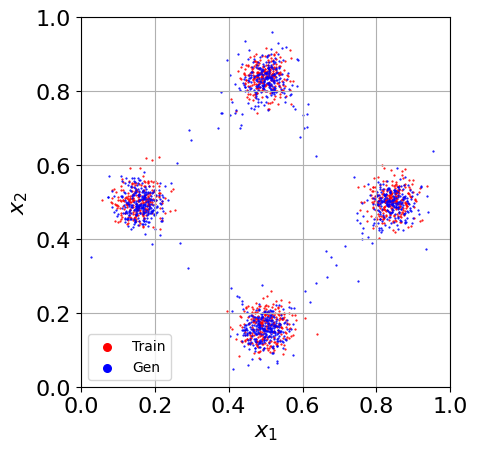

In [43]:
plt.scatter(X_train[:samples.shape[0], 0], X_train[:samples.shape[0], 1], s=0.3, color='red',label='Train')
plt.scatter(samples[:,0],samples[:,1],s=0.3,color='blue',label='Gen')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect('equal')
plt.grid()
lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]
